In [1]:
import json
import pickle
import logging
import os
import warnings

import joblib
import mlflow
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_fscore_support, 
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

### Model building baseline with mlflow tracking 

#### Carga de la data

In [32]:
def read_csv(file_name: str, path="../data/data_procesada") -> pd.DataFrame:
    """
    Read csv file
    :param file_name: file name
    :param path: path to the file
    :return: pandas dataframe
    """
    return pd.read_csv(os.path.join(path, file_name))

In [33]:
df_tickets = read_csv("tickets_inputs_eng_1.csv")
print(df_tickets.shape)
df_tickets.sample(5)

(18961, 4)


,complaint_what_happened,ticket_classification,processed_text,relevant_topics
965,I have a total of XXXX inquiries on all thre...,"Credit reporting, credit repair services, or o...",inquiri credit bank / contact credit bureaus ...,Credit Report or Prepaid Card
17552,My sister was alerted via mail by Chase Bank t...,Bank account or service + Savings account,sister alert mail chase bank sever account chi...,Bank Account Services
3979,I have complained about the banks fine for ove...,Checking or savings account + Checking account,complain bank overdraft havent month bank char...,Bank Account Services
16900,My husband and my 14 year-old daughter opened ...,Bank account or service + Checking account,husband daughter check account chase graduat m...,Bank Account Services
16698,someone pretending to be my daughter filed a c...,Bank account or service + Other bank product/s...,someon daughter file claim chase bank money ch...,Bank Account Services


In [34]:
df_tickets.relevant_topics.value_counts() 

#originalmente lo indicaba como desbalanceado, al corregir los archivos del util los clasifica correctamente 
#por lo que no hay un gran desbalance

relevant_topics
Bank Account Services            7069
Credit Report or Prepaid Card    6295
Mortgage/Loan                    5597
Name: count, dtype: int64

#### Definición de funciones

Se definen las funciones que se usaran en la creación, evaluación y trackeo de modelos

In [31]:
# Toma el dataframe y lo devuelve en variables de entrada (X) y variables de salida (y)
# Como variables de entrada tendremos el texto procesado
# Como variable de salida (este es mi target) el tema relevante

def data_transform(df: pd.DataFrame):
    
    X = df["processed_text"]
    y = df["relevant_topics"]

    return X, y

In [35]:
# Toma el json donde se encuentra la descripción e id de los temas relevantes y devuelve un diccionario.
# Esto permite la conversion de los id de los temas relevantes a su descripción,
# facilitando la lectura de los resultados

def read_idx2label(json_path: str) -> pd.Series:
    
    with open(json_path) as f:
        idx2label = json.load(f)
    
    return idx2label

In [36]:
# Similar a la anterior pero al revés, transforma los temas relevantes a los id 

def decode_labels_into_idx(labels: pd.Series, idx2label: dict) -> pd.Series:

    return labels.map(idx2label)

In [37]:
# genera un objeto CountVectorizer con los valores de entrada
# CountVectorizer es una matriz que presenta, como columnas, todas las palabras (tokens en este caso) del corpus
# y, como filas, todos los tickets. Indica en cada ticket la cantidad de veces que aparece cada tokens
# este objeto es guardado en la carpeta auxiliares de data

def fit_transform(X: pd.Series) -> np.ndarray:
    
    count_vectorizer = CountVectorizer()
    X_vectorized = count_vectorizer.fit_transform(X)

    joblib.dump(count_vectorizer, '../data/auxiliares/count_vectorizer.pkl')
    logger.info("count vectorizer trained successfully stored")
    
    return X_vectorized

In [38]:
# genera un objeto TfidfTransformer con los valores del CountVectorizer
# TfidfTransformer es una matriz que presenta lo relevante que es una palabra (en este caso Token) según su aparición
# en dicho documento y su presencia en el corpus. Tal cual hace el TfidfVectorizer (explicado en utils). La diferencia 
# surge ya que TfidfVectorizer lo calcula directamente del documento, mientras que TfidfTransformer 
# necesito pasar primero por CountVectorizer
# este objeto es guardado en la carpeta auxiliares de data

def transform_tfidf(X_vectorized: object) -> np.ndarray:
    
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_vectorized)
    joblib.dump(X_tfidf, '../data/auxiliares/X_tfidf.pkl')
    logger.info("X_tfidf trained successfully stored")
    
    return X_tfidf

In [39]:
# serializa la data pasada y lo guarda en un archivo  pickle
# la serialización permite al usuario preservar el estado original del objeto 
# sin perder ninguna información relevante

def save_pickle(data, filename) -> None:

    filepath = os.path.join("..", "data", "auxiliares", f"{filename}.pkl")
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)

In [40]:
# separa la data en train y test, y lo guarda como un pickle

def split_train_test(X_tfidf: np.array, y: pd.Series, 
                     test_size: float = 0.3, random_state: int = 42) -> tuple:
   
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=test_size, random_state=random_state
    )
    save_pickle((X_train, y_train), "train")
    save_pickle((X_test, y_test),  "test")
    logger.info("data saved successfully in pickle files")
    
    return X_train, X_test, y_train, y_test

In [41]:
# toma el modelo, realiza las predicciones y muestra el reporte de la clasificación
# y devuelvo las métricas

def display_classification_report( model: object, 
                                  name_model: str, developer: str, 
                                  X_train: np.array, X_test: np.array, y_train: np.array, y_test: np.array,
                                  use_cv = False ):
       
    # inicializo el tracking,
    with mlflow.start_run(run_name=name_model):

        # logeo el modelo para trackearlos
        mlflow.sklearn.log_model(model, f"model_{name_model}")

        # logeo los parámetros para trackearlos
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)

        # Por las dudas vacío las métricas
        metric = []

        #realizo las perdiciones
        y_train_pred_proba = model.predict_proba(X_train)
        y_test_pred_proba = model.predict_proba(X_test)
        
        # calculo los score utilizando curvas ROC. (enfrenta el ratio de falsos positivos  
        # con el ratio de falsos negativos )
        roc_auc_score_train = round( roc_auc_score(
            y_train, y_train_pred_proba, average="weighted", multi_class="ovr"
            ), 2)
        roc_auc_score_test = round( roc_auc_score(
            y_test, y_test_pred_proba, average="weighted", multi_class="ovr"
            ), 2)

        print("ROC AUC Score Train:", roc_auc_score_train)
        print("ROC AUC Score Test:", roc_auc_score_test)

        # realizo las perdiciones y calculamos las métricas
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        ( precision_train, recall_train, 
         fscore_train, support_train ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
        
        ( precision_test, recall_test, 
         fscore_test, support_test ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

        # logeo las métricas
        # logeo las métricas roc_auc de train y test para trackearlos
        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)
        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)

        #calculo la exactitud y la imprimo
        acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
        acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

        print("Train Accuracy: ", acc_score_train)
        print("Test Accuracy: ", acc_score_test)
        
        # agrego los valores a las métricas
        metric.extend([roc_auc_score_train, roc_auc_score_test])
        metric.extend([
                acc_score_train,
                acc_score_test,
                round(precision_train, 2),
                round(precision_test, 2),
                round(recall_train, 2),
                round(recall_test, 2),
                round(fscore_train, 2),
                round(fscore_test, 2),
            ])
        print('Métricas:', metric)

        # obtengo los mejores parámetros del modelo, dependiendo de que si definí el uso de validación cruzada o no
        # y lo trackeo
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            mlflow.log_params(best_params)

        except AttributeError as e:
            logger.info(f"Error: {e}")     
        
        # obtengo un reporte e imprimo
        model_report_train = classification_report(y_train, y_train_pred)
        model_report_test = classification_report(y_test, y_test_pred)

        print("Classification Report for Train:\n", model_report_train)
        print("Classification Report for Test:\n", model_report_test)


        # Ploteo la matriz de confusion 
        fig, ax = plt.subplots(figsize=(5, 5))

        # Creo la matriz de confusion 
        decoded_y_test_pred = [idx2label[idx] for idx in y_test_pred]
        decoded_y_test = [idx2label[idx] for idx in y_test]

        cm = confusion_matrix(decoded_y_test, decoded_y_test_pred)
        cmp = ConfusionMatrixDisplay(cm, display_labels=list(idx2label.values()))
        cmp.plot(ax=ax)

        plt.xticks(rotation=10, transform_rotates_text=True, horizontalalignment='right', verticalalignment='top')
        plt.show()

        #return metric



In [42]:
# realiza la búsqueda por grilla

def grid_search(model, folds, params, scoring):

    grid_search = GridSearchCV(
        model, cv=folds, param_grid=params, scoring=scoring, n_jobs=-1, verbose=1
    )

    return grid_search

In [43]:
# imprima el mejor score y los hyperparametros correspondientes

def print_best_score_params(model):
    """This functions print best score and best hyperparameters for baselines models
    Args:
        model (object): model
    Returns:
        None"""
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

#### Iniciar trackeo y preparar data

Para generar el archivo de base de datos (.db) y usarlo como tracking, ejecuto desde linea de comando:

```bash
mlflow ui --backend-store-uri sqlite:///tracking/mlflow.db
```

In [33]:
# Seteamos el archivo de tracking y el nombre del experimento:

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("tickets_baseline")

<Experiment: artifact_location=('file:///d:/Disco d/Milesi/01 - Personal/platzi/07 - Curso de '
 'MLOPS/tracking/mlruns/1'), creation_time=1708710405737, experiment_id='1', last_update_time=1708710405737, lifecycle_stage='active', name='tickets_baseline', tags={}>

In [44]:
#cargo los id y las etiquetas del target (y)
idx2label = read_idx2label(json_path="../data/data_procesada/topic_mapping_1.json")
label2idx = {value: key for key, value in idx2label.items()}

# cargo la data y cambio los id por las etiquetas del target
X, y = data_transform(df_tickets)
y = decode_labels_into_idx(labels=y, idx2label=label2idx)

# genero las matrices de relevancia
X_vectorized = fit_transform(X.values)
X_tfidf = transform_tfidf(X_vectorized)

# separo la data
X_train, X_test, y_train, y_test = split_train_test(X_tfidf, y)

INFO:__main__:count vectorizer trained successfully stored
INFO:__main__:X_tfidf trained successfully stored
INFO:__main__:data saved successfully in pickle files


In [19]:
# mlflow.end_run()

#### Generación de modelos

##### Modelo Multinomial Naive Bayes


2024/08/05 16:02:00 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logged at level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



ROC AUC Score Train: 0.97
ROC AUC Score Test: 0.96
Train Accuracy:  0.88
Test Accuracy:  0.86
Métricas: [0.97, 0.96, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86]
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4937
           1       0.87      0.88      0.87      4429
           2       0.93      0.81      0.87      3906

    accuracy                           0.88     13272
   macro avg       0.88      0.87      0.88     13272
weighted avg       0.88      0.88      0.88     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      2132
           1       0.84      0.85      0.84      1866
           2       0.92      0.79      0.85      1691

    accuracy                           0.86      5689
   macro avg       0.86      0.85      0.86      5689
weighted avg       0.86      0.86      0.86      5689



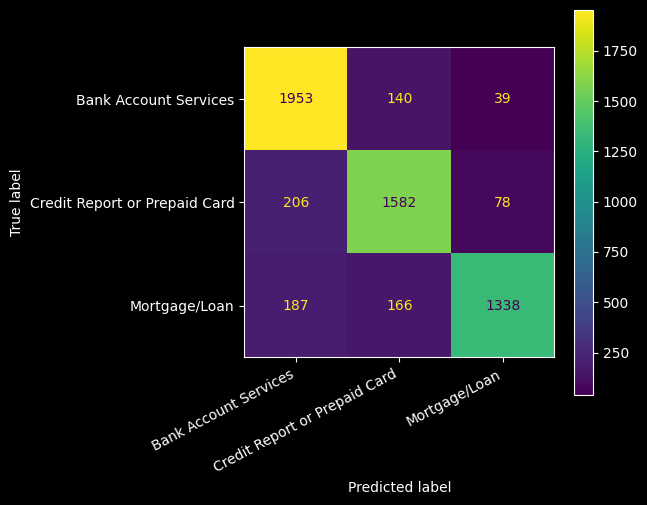

In [36]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
display_classification_report(model=mnb, 
                              name_model="MultinomialNB", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

##### Modelo Multinomial Naive Bayes con GreadSearch

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score:  0.8473478684769604
Best Hyperparameters:  {'alpha': 1}
ROC AUC Score Train: 0.97
ROC AUC Score Test: 0.96
Train Accuracy:  0.88
Test Accuracy:  0.86
Métricas: [0.97, 0.96, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86, 0.88, 0.86]
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4937
           1       0.87      0.88      0.87      4429
           2       0.93      0.81      0.87      3906

    accuracy                           0.88     13272
   macro avg       0.88      0.87      0.88     13272
weighted avg       0.88      0.88      0.88     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      2132
           1       0.84      0.85      0.84      1866
           2       0.92      0.79      0.85      1691

    accuracy                           0.

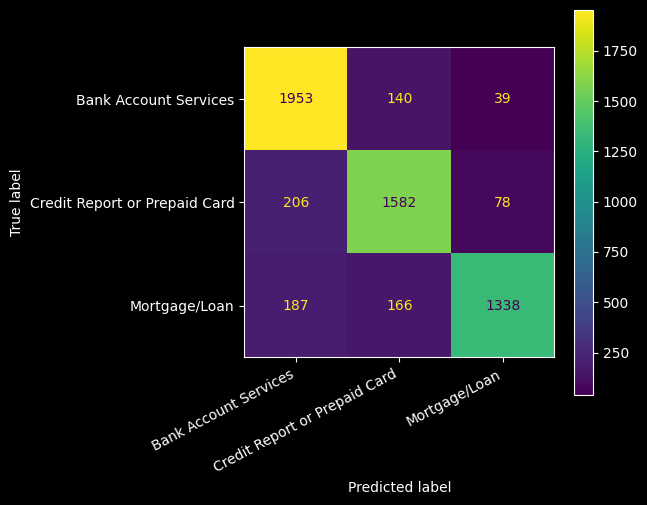

In [37]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)
mnb = MultinomialNB()
mnb_params = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
}
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring="f1_micro")
grid_search_mnb.fit(X_train, y_train)
print_best_score_params(grid_search_mnb)

display_classification_report(model=grid_search_mnb, 
                              name_model="MultinomialNBCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv= True)

##### Logistic Regression

ROC AUC Score Train: 1.0
ROC AUC Score Test: 1.0
Train Accuracy:  0.99
Test Accuracy:  0.97
Métricas: [1.0, 1.0, 0.99, 0.97, 0.99, 0.97, 0.99, 0.97, 0.99, 0.97]
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4937
           1       0.98      1.00      0.99      4429
           2       1.00      0.98      0.99      3906

    accuracy                           0.99     13272
   macro avg       0.99      0.99      0.99     13272
weighted avg       0.99      0.99      0.99     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      2132
           1       0.96      0.98      0.97      1866
           2       0.98      0.96      0.97      1691

    accuracy                           0.97      5689
   macro avg       0.97      0.97      0.97      5689
weighted avg       0.97      0.97      0.97      5689



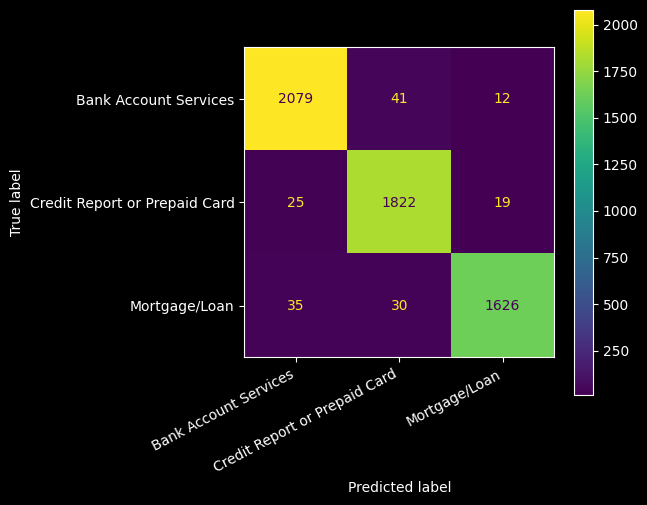

In [38]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
display_classification_report(model=log_reg, 
                              name_model="LogisticRegression", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=False)

##### Logistic Regression with GreadSearch

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.9837284419157456
Best Hyperparameters:  {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
ROC AUC Score Train: 1.0
ROC AUC Score Test: 1.0
Train Accuracy:  1.0
Test Accuracy:  0.98
Métricas: [1.0, 1.0, 1.0, 0.98, 1.0, 0.98, 1.0, 0.98, 1.0, 0.98]
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4937
           1       1.00      1.00      1.00      4937
           2       1.00      1.00      1.00      4937

    accuracy                           1.00     14811
   macro avg       1.00      1.00      1.00     14811
weighted avg       1.00      1.00      1.00     14811

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      2132
           1       0.98      0.98      0.98      1866
           2       0.98      0.99      0.98      1691

    accuracy     

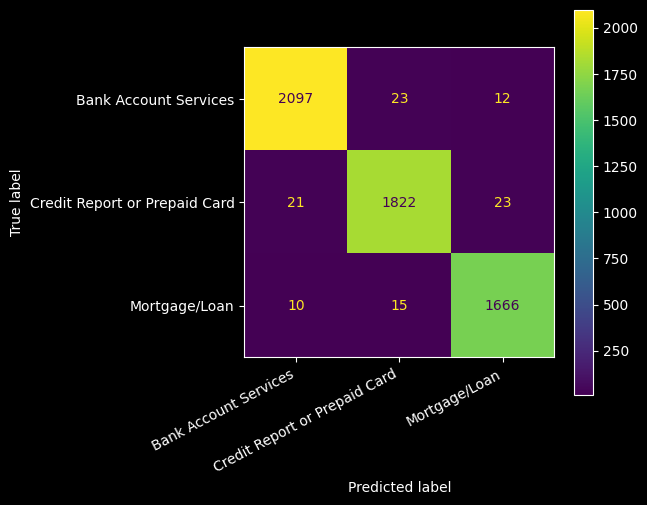

In [39]:
# rebalance of the data
smote = SMOTE()
# transform the dataset with the SMOTE algorithm
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# define the model with the balanced class_weight
log_reg = LogisticRegression(class_weight='balanced')

log_params = {'C': [0.01, 1, 10], 
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

grid_search_log = grid_search(log_reg, folds, log_params, scoring="f1_micro")
grid_search_log.fit(X_train_res, y_train_res)  # entrenamiento con los datos rebalanceados

print_best_score_params(grid_search_log)
display_classification_report(grid_search_log,
                              name_model="LogisticRegressionCVSmote", 
                              developer="Maria", 
                              X_train=X_train_res,  # evaluación con los datos rebalanceados
                              X_test=X_test, 
                              y_train=y_train_res,  # etiquetas rebalanceadas
                              y_test=y_test, 
                              use_cv=True)

##### Decision Tree Classifier

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.89
Train Accuracy:  1.0
Test Accuracy:  0.86
Métricas: [1.0, 0.89, 1.0, 0.86, 1.0, 0.86, 1.0, 0.86, 1.0, 0.86]
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4937
           1       1.00      1.00      1.00      4429
           2       1.00      1.00      1.00      3906

    accuracy                           1.00     13272
   macro avg       1.00      1.00      1.00     13272
weighted avg       1.00      1.00      1.00     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2132
           1       0.86      0.86      0.86      1866
           2       0.85      0.85      0.85      1691

    accuracy                           0.86      5689
   macro avg       0.86      0.86      0.86      5689
weighted avg       0.86      0.86      0.86      5689



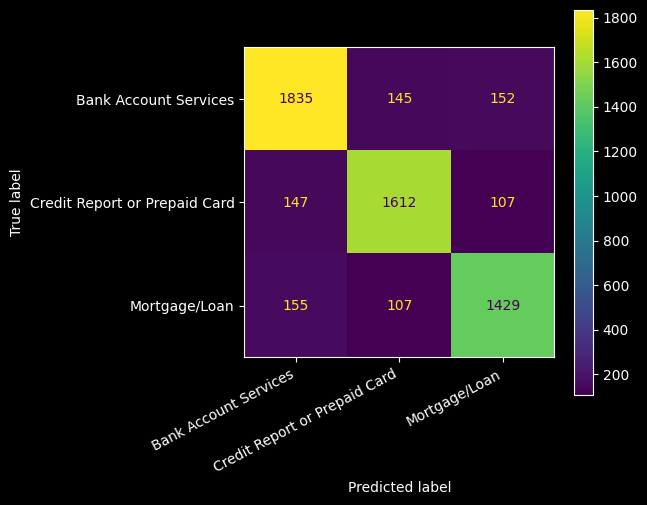

In [40]:
dtc = DecisionTreeClassifier(random_state=40)
dtc.fit(X_train,y_train)
display_classification_report(model=dtc,
                              name_model="DecisionTreeClassifier",
                              developer="Maria",
                              X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test,
                              use_cv=False)

##### Decision Tree Classifier with Gread Search

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best Score:  0.870619206133405
Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 7, 'splitter': 'best'}
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.94
Train Accuracy:  0.94
Test Accuracy:  0.87
Métricas: [1.0, 0.94, 0.94, 0.87, 0.94, 0.87, 0.94, 0.87, 0.94, 0.87]
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      4937
           1       0.94      0.96      0.95      4429
           2       0.95      0.93      0.94      3906

    accuracy                           0.94     13272
   macro avg       0.94      0.94      0.94     13272
weighted avg       0.94      0.94      0.94     13272

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2132
           1       0.86      0.89      0.88      1866

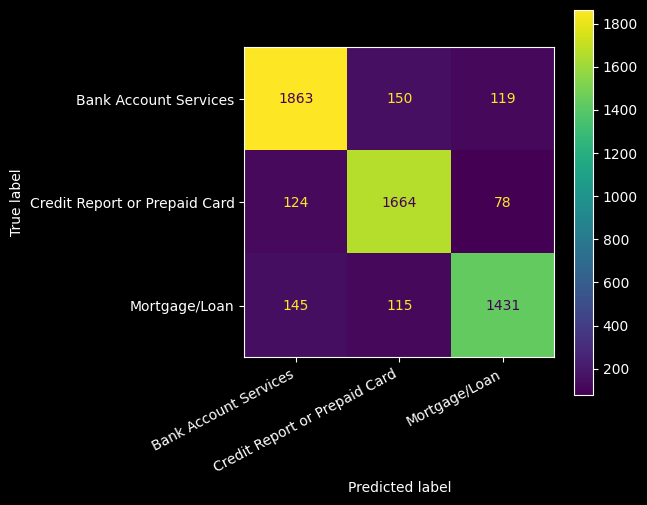

In [41]:
# decis|on tree classifier with grid search
dtc_cv = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2,3,4,5,6,7,8,None],
    'min_samples_leaf': [2,3,4,7],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
grid_search_dtc = grid_search(dtc_cv, folds, dtc_params, scoring='f1_macro')
grid_search_dtc.fit(X_train, y_train)
print_best_score_params(grid_search_dtc)
display_classification_report(grid_search_dtc, 
                              name_model="DecisionTreeClassifierCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=True)

#### Hacer inferencias con el modelo

```bash
mlflow ui --backend-store-uri sqlite:///tracking/mlflow.db
```

In [42]:
# cargo un modelo de los que ya están generados, obtengo el modelo desde mlflow
# para este caso tomo el modelo de LogisticRegressionCVSmote y obtengo la ruta del modelo, ingresando en su detalle,
# Artifacts -> click sobre la carpeta del modelo. A la derecha aparecerá un modelo de Scripts para la carga y
# copio el logged_model

logged_model = 'runs:/4733f36677b1404aae6bce41936c714f/model_LogisticRegressionCVSmote'

# y cargo el modelo como un PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [43]:
# hago una verificación de dimensiones entre los datos de entrenamiento
assert X_train.toarray().shape[0] == y_train.shape[0]

In [44]:
# muestro los datos del modelo
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model_LogisticRegressionCVSmote
  flavor: mlflow.sklearn
  run_id: 4733f36677b1404aae6bce41936c714f

In [45]:
# lo cargo como un modelo sklearn

lr_model = mlflow.sklearn.load_model(logged_model)
lr_model.get_params()

{'cv': StratifiedKFold(n_splits=5, random_state=40, shuffle=True),
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__class_weight': 'balanced',
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(class_weight='balanced'),
 'n_jobs': -1,
 'param_grid': {'C': [0.01, 1, 10],
  'penalty': ['l1', 'l2'],
  'solver': ['liblinear', 'newton-cg', 'saga']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'f1_micro',
 'verbose': 1}

In [46]:
# hago una perdición

lr_model.predict(X_test)

array(['2', '0', '2', ..., '1', '0', '0'], dtype=object)

Con el modelo cargado, lo puedo manejar como siempre 

In [17]:
# ahora voy a conectar con el client del MLflow para obtener los experimentos realizados y la información de estos

from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [18]:
# Seteamos el archivo de tracking y el nombre del experimento:

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("tickets_baseline")

<Experiment: artifact_location=('file:///d:/Disco d/Milesi/01 - Personal/platzi/07 - Curso de '
 'MLOPS/tracking/mlruns/1'), creation_time=1708710405737, experiment_id='1', last_update_time=1708710405737, lifecycle_stage='active', name='tickets_baseline', tags={}>

In [19]:
runs = mlflow.search_runs()
# Extrae los IDs únicos de los experimentos
experiment_ids = runs['experiment_id'].unique()

experiment_ids

array(['1'], dtype=object)

Figura uno por que solo hay un experimento

<p align="center">
    <img src="./image/Experimento 1.png">
</p>

In [21]:
client.create_experiment("regression_models2")

experiment_ids = runs['experiment_id'].unique()

experiment_ids

array(['1'], dtype=object)

Si creo un nuevo experimento, sigue apareciendo 1 por que esta vacío, pero se genero el "regression_models" 

<p align="center">
    <img src="./image/Experimento 2.png">
</p>

In [51]:
# muestro la info de los experimentos

runs = client.search_runs(experiment_ids=["1"])
for run in runs:
    print(run.info)

<RunInfo: artifact_uri=('file:///d:/Disco d/Milesi/01 - Personal/platzi/07 - Curso de '
 'MLOPS/tracking/mlruns/1/09a0ff017da94ae48d66eec5f3324e00/artifacts'), end_time=1722884804106, experiment_id='1', lifecycle_stage='active', run_id='09a0ff017da94ae48d66eec5f3324e00', run_name='DecisionTreeClassifierCV', run_uuid='09a0ff017da94ae48d66eec5f3324e00', start_time=1722884798737, status='FINISHED', user_id='Ignacio.Milesi'>
<RunInfo: artifact_uri=('file:///d:/Disco d/Milesi/01 - Personal/platzi/07 - Curso de '
 'MLOPS/tracking/mlruns/1/d57fc0494f094d9996f93c15479c4b6f/artifacts'), end_time=1722884625380, experiment_id='1', lifecycle_stage='active', run_id='d57fc0494f094d9996f93c15479c4b6f', run_name='DecisionTreeClassifier', run_uuid='d57fc0494f094d9996f93c15479c4b6f', start_time=1722884619950, status='FINISHED', user_id='Ignacio.Milesi'>
<RunInfo: artifact_uri=('file:///d:/Disco d/Milesi/01 - Personal/platzi/07 - Curso de '
 'MLOPS/tracking/mlruns/1/856e7970c924402986095fecbc635f40/artif

#### Promover modelo desde UI

Ahora vayamos a la UI y promovamos a un par de modelos con mejor performance. 

Ordenamos los modelos por mejor performance e ingresamos en el detalle. Abajo a la derecha veremos veremos el botón "Register Model" y al hacer click aparecerá:

<p align="center">
    <img src="./image/register Model.png">
</p>

Como no tengo ninguno generado solo aparece para crear uno, lo cual realizamos. Al finalizar el registro podemos verlo abajo a la derecha:

<p align="center">
    <img src="./image/modelo registrado.png">
</p>

y al hacer click vemos sus opciones. En stage puedo definir que estado lo tengo al modelo registrado

<p align="center">
    <img src="./image/seleccion de stage.png">
</p>

lo marcamos como staging ( es un estado intermedio, donde se pueden realizar verificaciones y desde donde sera tomado por otro estado). Deseleccionamos la opción para tener varios modelos en este estado, en caso contrario solo permitirá uno (el ultimo que se asigne) y los anteriores los archivaría

<p align="center">
    <img src="./image/seleccion staging.png">
</p>

También agregamos una tag, en este caso, la técnica del modelo marcado

<p align="center">
    <img src="./image/tag.png">
</p>

Realizo los mismos pasos para el segundo mejor modelo, con la salvedad que ya tengo un modelo registrado, no necesito crearlo sino que lo selecciono.

Ahora si vuelvo a experimentos veré que modelos están registrados

<p align="center">
    <img src="./image/visualizacion de model en experimentos.png">
</p>

y si voy a la pestaña model (arriba) podre ver los modelos creados y al seleccionarlos cuales los experimentos tengo marcados en ellos

<p align="center">
    <img src="./image/visualizacion de model en model.png">
</p>

La idea de promoverlos es la de marcarlos e identificar con que modelos voy a trabajar

### Promote a model

Lo mismo que el paso anterior pero desde codigo

In [24]:
# obtenemos los 5 mejores modelos y los muestro

runs= client.search_runs(
    experiment_ids='1',# el ID lo puedo obtener desde la UI debajo del nombre del experimento, 
                        # también podría hacer runs['experiment_id'].unique()
    filter_string="", # se puede usar un tag en especial o algún parámetro de interés ej: 'tags.model = valor que usaste
    run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.precision_test DESC"]

)


for run in runs:
    print(f"run id: {run.info.run_id}, rmse_valid: {run.data.metrics['precision_test']}")

run id: 4733f36677b1404aae6bce41936c714f, rmse_valid: 0.9822602430765659
run id: 856e7970c924402986095fecbc635f40, rmse_valid: 0.9817234856732325
run id: 5b98dcd5fcb241a0a1f1ab1b8bcedda9, rmse_valid: 0.9716247042374007
run id: 84b4e1573d2d498abfd732b4a99ead2d, rmse_valid: 0.9716247042374007
run id: 09a0ff017da94ae48d66eec5f3324e00, rmse_valid: 0.8716876918644566


In [25]:
# Voy a tomar el primer run (el de mejor precisión) y 
# lo voy registrar como un modelo "Ticket_classifier" (el creado en el paso anterior)

run_id = "4733f36677b1404aae6bce41936c714f"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri, "Ticket_classifier")

Registered model 'Ticket_classifier' already exists. Creating a new version of this model...
Created version '3' of model 'Ticket_classifier'.


<ModelVersion: aliases=[], creation_timestamp=1722963894708, current_stage='None', description=None, last_updated_timestamp=1722963894708, name='Ticket_classifier', run_id='4733f36677b1404aae6bce41936c714f', run_link=None, source=('file:///d:/Disco d/Milesi/01 - Personal/platzi/07 - Curso de '
 'MLOPS/tracking/mlruns/1/4733f36677b1404aae6bce41936c714f/artifacts/model'), status='READY', status_message=None, tags={}, user_id=None, version=3>

Devuelve que ya existe ese modelo, lo que hará es crear la version 3 del mismo

In [26]:
# voy a consultar en que stage se encuentra el modelo "Ticket_classifier"
model_name = "Ticket_classifier"
latest_versions = client.get_latest_versions(name=model_name)
for version in latest_versions:
    print(f" version: {version.version} , actual stage: {version._current_stage}")

 version: 2 , actual stage: Staging
 version: 3 , actual stage: None


Me devuelve las ultimas dos versiones y me indica que la version 2 esta en Staging, mientras que la 3 no tiene asignado nada

In [27]:
# voy a pedir que pase la version 3 a Staging, la 2 a Production y actualice la descripción

model_name_2 = "Ticket_classifier"

client.transition_model_version_stage(
    name=model_name_2,
    version=3,
    stage="Staging"
)

client.transition_model_version_stage(
    name=model_name_2,
    version=2,
    stage="Production"
)

client.update_model_version(
    name=model_name_2, 
    version=2,
    description=f"The model version {2} was transitioned to Production on {datetime.today().date()}"
)

<ModelVersion: aliases=[], creation_timestamp=1722960875550, current_stage='Production', description='The model version 2 was transitioned to Production on 2024-08-06', last_updated_timestamp=1722964549091, name='Ticket_classifier', run_id='09a0ff017da94ae48d66eec5f3324e00', run_link='', source=('file:///d:/Disco d/Milesi/01 - Personal/platzi/07 - Curso de '
 'MLOPS/tracking/mlruns/1/09a0ff017da94ae48d66eec5f3324e00/artifacts/model_DecisionTreeClassifierCV'), status='READY', status_message=None, tags={'model': 'Decision Tree'}, user_id=None, version=2>

In [29]:
# realizo la consulta para ver los cambios realizados
model_name = "Ticket_classifier"
latest_versions = client.get_latest_versions(name=model_name)
for version in latest_versions:
    print(f" version: {version.version} , actual stage: {version._current_stage}, Descripcion: {version.description}")

 version: 3 , actual stage: Staging, Descripcion: None
 version: 2 , actual stage: Production, Descripcion: The model version 2 was transitioned to Production on 2024-08-06


In [45]:
type(y_test)

pandas.core.series.Series

## Sometamos a prueba el modelo que hemos registrado para producción

La idea es tomar el modelo y estado indicado y realizar una perdición

In [46]:
import scipy

In [47]:
def testint_model_from_mlflow(model_name: str, stage:str, X_test: scipy.sparse._csr.csr_matrix, Y_test: pd.Series):
    """this function tests a model from mlflow
    Args:
        model_name (str): name of the model
        stage (str): stage of the model
        X_test (scipy.sparse._csr.csr_matrix): test data
        Y_test (scipy.sparse._csr.csr_matrix): test target
    Returns:
        float: rmse of the model
    
    """
    model_uri = f"models:/{model_name}/{stage}"
    model = mlflow.pyfunc.load_model(model_uri)
    y_pred = model.predict(X_test)
    acc_score = round(accuracy_score(Y_test, y_pred), 2)
    return {"rmse": acc_score}

In [49]:
%time
testint_model_from_mlflow(model_name= "Ticket_classifier", stage="Production", X_test=X_test, Y_test=y_test)

CPU times: total: 0 ns
Wall time: 0 ns


{'rmse': 0.87}

Me devuelve una exactitud de 0.87 del modelo en producción

## Ventajas de MLflow:

* Gestión de Ciclo de Vida: Facilita el seguimiento de experimentos, versionado de modelos y reproducción de resultados.
* Interoperabilidad: Es compatible con múltiples frameworks de aprendizaje automático y se integra fácilmente en flujos de trabajo existentes.
* Abierto y Modular: Ofrece una arquitectura modular que permite la flexibilidad y personalización.
* Trazabilidad y Reproducibilidad: Registra métricas, parámetros y artefactos para reproducir modelos y resultados.
* Comunidad Activa: Amplia comunidad de usuarios y contribuciones continuas.

## Desventajas de MLflow:
* Complejidad para Grandes Volúmenes de Datos: Puede enfrentar dificultades al manejar grandes volúmenes de datos o flujos de trabajo muy complejos.
* Curva de Aprendizaje: Requiere tiempo para familiarizarse con todas sus funcionalidades y componentes.
* Limitaciones en Algunas Funcionalidades: Algunas funcionalidades pueden no ser tan avanzadas o flexibles como en otras herramientas especializadas.

## Alternativas a MLflow:
* TensorBoard: Enfoque específico para TensorFlow, útil para visualizar gráficamente métricas, grafos de modelos y más.
* DVC (Data Version Control): Se enfoca en versionado de datos y modelos, y gestión de experimentos.
* Comet.ml: Ofrece seguimiento de experimentos, colaboración y visualización de manera similar a MLflow.
* Weights & Biases: Ofrece seguimiento de experimentos, colaboración y visualización de manera similar a MLflow.


## 💚 Conclusiones
* Podemos trackear metadata

* Registrar modelos

* Obtener los requirimientos del ambiente de desarrollo donde fue entrenado los modelos

* Podemos hacer un seguimiento de los modelos y compararlos de forma fácil y amigable con la interfaz de MLflow y en código

